# TO DO LIST

11. capire come fare una prediction con quanto ottenuto
14. devo usare il test e validation set? si come? vedere l autoencoder come si comporta con dati non visti ?
15. aggiungere un early stopping
17. sistemare la sindy library con qualcosa di piu sensato
18. capire se i parametri xi effettivamente debbano essere agggiornati dal gradiente o no



In [ ]:
import matplotlib.pyplot as plt
from google.colab import files
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import sys
syspath = 'SindyPendulum/'
if syspath not in sys.path:
    sys.path.append(syspath)
import time


In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


# Data Generation

In [ ]:
!git clone https://github.com/pietro-sillano/SindyPendulum.git

fatal: destination path 'SindyPendulum' already exists and is not an empty directory.


In [ ]:
!cd SindyPendulum && git pull

Already up to date.


In [ ]:
from sindy_library import SINDyLibrary

In [ ]:
from sindy_library_numpy import SINDyNew

In [ ]:
#!python SindyPendulum/lorentz.py  -i 1000

In [ ]:
!python SindyPendulum/data_pendulum_image.py  -i 90

tcmalloc: large alloc 4910694400 bytes == 0x55a099142000 @  0x7fea6f3811e7 0x7fea6cf0146e 0x7fea6cf51c7b 0x7fea6cf5235f 0x7fea6cff4103 0x55a096987544 0x55a096987240 0x55a0969fb627 0x55a096988afa 0x55a0969f6915 0x55a0969f59ee 0x55a0969f56f3 0x55a096abf4c2 0x55a096abf83d 0x55a096abf6e6 0x55a096a97163 0x55a096a96e0c 0x7fea6e16bbf7 0x55a096a96cea
tcmalloc: large alloc 4910694400 bytes == 0x55a1bdc76000 @  0x7fea6f3811e7 0x7fea6cf0146e 0x7fea6cf51c7b 0x7fea6cf5235f 0x7fea6cff4103 0x55a096987544 0x55a096987240 0x55a0969fb627 0x55a096988afa 0x55a0969f6915 0x55a0969f59ee 0x55a0969f56f3 0x55a096abf4c2 0x55a096abf83d 0x55a096abf6e6 0x55a096a97163 0x55a096a96e0c 0x7fea6e16bbf7 0x55a096a96cea
0  su  4720
100  su  4720
200  su  4720
300  su  4720
400  su  4720
500  su  4720
600  su  4720
700  su  4720
800  su  4720
900  su  4720
1000  su  4720
1100  su  4720
1200  su  4720
1300  su  4720
1400  su  4720
1500  su  4720
1600  su  4720
1700  su  4720
1800  su  4720
1900  su  4720
2000  su  4720
2100  s

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/My Drive/

ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive/': No such file or directory


In [ ]:
!mv X.npy /content/gdrive/MyDrive/

In [ ]:
!mv Xdot.npy /content/gdrive/MyDrive/

In [ ]:
X = np.load('/content/gdrive/MyDrive/X.npy')
Xdot = np.load('/content/gdrive/MyDrive/Xdot.npy')

KeyboardInterrupt: ignored

In [ ]:
X.dtype

dtype('float32')

In [ ]:
X = torch.from_numpy(X).float().to(device)
Xdot = torch.from_numpy(Xdot).float().to(device)
X.shape, Xdot.shape, X.dtype

In [ ]:
batch_size = 1024
my_dataset = TensorDataset(X,Xdot)
dataloader = DataLoader(my_dataset,batch_size=batch_size, shuffle=True)

# Network




In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size,512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,latent_dim)
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            print(m)
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        #x = torch.sigmoid(self.fc1(x))
        
        #x = torch.sigmoid(self.fc2(x))
        #x = torch.sigmoid(self.fc3(x))   
        #x = torch.sigmoid(self.fc4(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))   
        x = torch.relu(self.fc4(x))
        return x 

class Decoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim,64)
        self.fc2 = nn.Linear(64,128)
        self.fc3 = nn.Linear(128,512)
        self.fc4 = nn.Linear(512,input_size)
        self.initialize_weights()

    def forward(self, x):
        #x = torch.sigmoid(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
        #x = torch.sigmoid(self.fc3(x))   
        #x = torch.sigmoid(self.fc4(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))   
        x = torch.relu(self.fc4(x))
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_size,latent_dim)
        self.decoder = Decoder(input_size,latent_dim)
        self.SINDyLibrary = SINDyLibrary(
            device=device,
            latent_dim=latent_dim,
            include_biases=False,
            include_states=True,
            include_sin=True,
            include_cos=True,
            include_multiply_pairs=True,
            poly_order=2,
            include_sqrt=True,
            include_inverse=False,
            include_sign_sqrt_of_diff=False)
        
#        self.XI = nn.Parameter(torch.full((self.SINDyLibrary.number_candidate_functions,latent_dim), 0.1,dtype = torch.float32,requires_grad=True,device = device))
        self.XI = nn.Parameter(torch.full((self.SINDyLibrary.number_candidate_functions,latent_dim), 0.1,dtype = torch.float32,requires_grad=True,device = device))

        self.XI_coefficient_mask = torch.ones((self.SINDyLibrary.number_candidate_functions,latent_dim),dtype = torch.float32, device=device)

    def configure_optimizers(self):
        learning_rate = 1e-4
#        return torch.optim.SGD(self.parameters(), lr=learning_rate)
        return torch.optim.Adam(self.parameters(), lr=learning_rate)


    def t_derivative(self,input, xdot, weights, biases, activation='sigmoid'):
        """
        Compute the first order time derivatives by propagating through the network.
        da[l]dt = xdot * da[l]dx = xdot * product(g'(w[l]a[l-1] + b[l])* w[l])
        Arguments:
            input - 2D tensorflow array, input to the network. Dimensions are number of time points
            by number of state variables.
            xdot - First order time derivatives of the input to the network. quello che conosciamo
            weights - List of tensorflow arrays containing the network weights
            biases - List of tensorflow arrays containing the network biases
            activation - String specifying which activation function to use. Options are
            'elu' (exponential linear unit), 'relu' (rectified linear unit), 'sigmoid',
            or linear.

        Returns:
            dadt - Tensorflow array, first order time derivatives of the network output.
        """
        a   = input
        dadt = xdot #per le condizioni iniziali

        if activation == 'sigmoid':
            for i in range(len(weights) - 1):
                z = torch.matmul(a, weights[i].T) + biases[i]
                a = torch.sigmoid(z)
                gprime = a * (1-a)
                dadt = gprime * torch.matmul(dadt, weights[i].T)
            dadt = torch.matmul(dadt, weights[-1].T) #fuori dal ciclo bisogna ancora moltiplicare per i pesi dell ultimo livello
            
        elif activation == 'relu':
            for i in range(len(weights) - 1):
                #print('modulo n ',i)
                #print('weights',weights[i].shape)
                z = torch.matmul(a, weights[i].T) + biases[i]
                #print('z:',z.shape)
                a = torch.relu(z)
                #print('a:',a.shape)
                dadt = (z > 0).float() * torch.matmul(dadt, weights[i].T)    
            dadt = torch.matmul(dadt, weights[-1].T) #fuori dal ciclo bisogna ancora moltiplicare per i pesi dell ultimo livello
            #print(dadt)
        return dadt #nel caso che ci serve dadt sará l output dell encoder ossia le latent variables!

    
    
    def compute_quantities(self,x,xdot):
    
        z = self.encoder(x)
        xtilde = self.decoder(z)

        theta = self.SINDyLibrary.transform(z) 
        zdot_hat = torch.matmul(theta, self.XI_coefficient_mask * self.XI)
        
        encoder_parameters = list(self.encoder.parameters())
        encoder_weight_list = [w for w in encoder_parameters if len(w.shape) == 2]
        encoder_biases_list = [b for b in encoder_parameters if len(b.shape) == 1]
        zdot = self.t_derivative(x, xdot, encoder_weight_list, encoder_biases_list, activation='relu')                                               

        #print("propagazione sul decoder")
        decoder_parameters = list(self.decoder.parameters())
        decoder_weight_list = [w for w in decoder_parameters if len(w.shape) == 2]
        decoder_biases_list = [b for b in decoder_parameters if len(b.shape) == 1]
        xtildedot = self.t_derivative(z, zdot_hat, decoder_weight_list, decoder_biases_list, activation='relu')    
        
        if(DEBUG == True):
            print('z',z)
            print(' xtilde',xtilde)
            print('theta',theta)
            print('max theta',theta.max())
            print('zdot',zdot)
            print('zdothat',zdot_hat)
            print('xtildedot',xtildedot)


        return xtilde, xtildedot, z, zdot, zdot_hat

    def loss_function(self, x, xdot, xtilde, xtildedot, zdot, zdot_hat,XI):
        mse = nn.MSELoss()
        alpha1 = 5e-4
        alpha2 = 5e-5
        alpha3 = 1e-5
        loss = {}
        loss['recon_loss'] = mse(x, xtilde) #errore di ricostruzione 
        loss ['sindy_loss_x'] = mse(xdot, xtildedot) 
        loss ['sindy_loss_z'] = mse(zdot, zdot_hat) 
        loss['sindy_regular_loss'] = torch.sum(torch.abs(XI)) #norma L1 degli XI
        loss['tot'] = loss['recon_loss'] + alpha1*loss['sindy_loss_x'] + alpha2*loss['sindy_loss_z'] + alpha3*loss['sindy_regular_loss']
        tot = loss['tot']
        return tot, loss
    
    def forward(self, x, xdot):
        return self.compute_quantities(x, xdot)

In [ ]:
input_size = X.shape[1]
latent_dim = 2

In [ ]:
model = Autoencoder(input_size,latent_dim).to(device)

In [ ]:
model.SINDyLibrary.number_candidate_functions

# Parameters and Training


In [ ]:
def sequential_threshold(t):
    if t % 100 == 0:
        model.XI_coefficient_mask = torch.abs(model.XI) > 0.01
        print(model.XI_coefficient_mask)

        f1 = './model'+str(batch_size)+'_'+str(t)+'epochs'+'.pt'
        torch.save(model,f1)
        print('salvato il',f1)
        #files.download(f1)

In [ ]:
epochs = 1000
DEBUG = False

loss_list = {}
loss_list['recon_loss'] = []
loss_list['sindy_loss_x'] = []
loss_list['sindy_loss_z'] = []
loss_list['sindy_regular_loss'] = []
loss_list['tot'] = []

for t in range(epochs):
    start = time.time()
    model.train()
    
    #queste serve per le loss di ogni batch
    loss_epoch = {}
    loss_epoch['recon_loss'] = []
    loss_epoch['sindy_loss_x'] = []
    loss_epoch['sindy_loss_z'] = []
    loss_epoch['sindy_regular_loss'] = []
    loss_epoch['tot'] = []
    
    
    for batch, (X,Xdot) in enumerate (dataloader):
        X.to(device) #per passarlo alla gpu
        Xdot.to(device)
        #forward pass 
        xtilde, xtildedot, z, zdot, zdot_hat = model(X,Xdot)

        # Backpropagation
        optimizer = model.configure_optimizers()
        loss, loss_dict = model.loss_function(X, Xdot, xtilde, xtildedot, zdot, zdot_hat,model.XI)
        loss.backward()
        del  xtilde, xtildedot, z, zdot, zdot_hat,loss
        optimizer.step()
        optimizer.zero_grad()

        current = batch * len(X)

        for key in loss_epoch.keys():
            loss_epoch[key].append(loss_dict[key].item())
        del loss_dict

    for key in loss_epoch.keys():
        loss_list[key].append(sum(loss_epoch[key])/len(loss_epoch[key]))
    del loss_epoch
    
    end = time.time()
    if t % 5 == 0:
        print()
        print(f"Epoch {t}\n-------------------------------")
        for key in loss_list.keys():
            temp = loss_list[key]
            print(f'{key} of epoch {t}: {temp[-1]}')
        print('time: ',end-start)


    sequential_threshold(t)

print("Done!")
torch.save(model,'./model.pt')


In [ ]:
torch.save(model,'./model'+str(batch_size)+'_'+str(t)+'epochs'+'.pt')

### loss 8192 100 epochs
recon_loss of epoch 99: 85.203
sindy_loss_x of epoch 99: 3025.53
sindy_loss_z of epoch 99: 46474.64
sindy_regular_loss of epoch 99: 14.79
tot of epoch 99: 89.040

### loss con 1024 bs 100 epochs
recon_loss of epoch 99: 7.975912475585938
sindy_loss_x of epoch 99: 1166.713880266462
sindy_loss_z of epoch 99: 16406.63359375
sindy_regular_loss of epoch 99: 12.32967277935573
tot of epoch 99: 9.379724172183446

### loss con 256 batchsize 100 epochs
recon_loss of epoch 99: 22.13456918171474
sindy_loss_x of epoch 99: 738.3788791111538
sindy_loss_z of epoch 99: 31111.867034040177
sindy_regular_loss of epoch 99: 9.434283091340745
tot of epoch 99: 24.059446038518633


conclusione la miglior batchsize sembra essere 1024 !


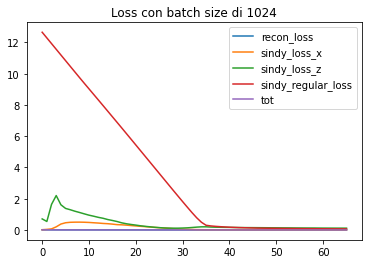

In [ ]:
import pandas as pd
data = pd.DataFrame.from_dict(loss_list)
data.to_csv('./data'+str(batch_size)+'.csv')
torch.save(model,'./model'+str(batch_size)+'.pt')
for key in loss_list.keys():
    plt.plot(loss_list[key],label = key)
    plt.legend(loc = 'best')
    plt.title('Loss con batch size di '+str(batch_size))

In [ ]:
model.SINDyLibrary.get_feature_names()

['z0',
 'z1',
 'sin(z0)',
 'sin(z1)',
 'cos(z0)',
 'cos(z1)',
 'z0*z1',
 'z0*z0*z0',
 'z0*z0*z1',
 'z0*z1*z1',
 'z1*z1*z1',
 'sqrt(z0)',
 'sqrt(z1)']

In [ ]:
model.XI_coefficient_mask

tensor([[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [ True,  True],
        [False, False],
        [False, False]], device='cuda:0')

In [ ]:
model.XI

Parameter containing:
tensor([[-7.6597e-05,  7.6021e-05],
        [-1.1938e-05, -7.5648e-05],
        [-4.1007e-05, -3.2785e-05],
        [ 1.4124e-05,  4.8324e-05],
        [ 1.3394e-05,  4.8808e-05],
        [-6.2902e-06,  9.0362e-05],
        [-3.5040e-05, -1.1418e-05],
        [ 5.8476e-03,  6.5331e-03],
        [-8.4854e-06, -9.9796e-05],
        [-9.9011e-05, -3.3356e-05],
        [ 1.0586e-02,  1.2025e-02],
        [ 2.1010e-05, -7.2086e-05],
        [ 6.6925e-05, -3.4836e-05]], device='cuda:0', requires_grad=True)

In [ ]:
np.multiply(model.XI.cpu().detach().numpy(),model.XI_coefficient_mask.cpu().detach().numpy())

array([[-0.        ,  0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.00584755,  0.00653313],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       [ 0.01058594,  0.01202497],
       [ 0.        , -0.        ],
       [ 0.        , -0.        ]], dtype=float32)

# idee sul plotting
quello che potrei fare é stampare il recupero della dinamica a seconda delle epoche di training

In [ ]:
sl = SINDyNew(latent_dim=latent_dim,
            include_biases=False,
            include_states=True,
            include_sin=True,
            include_cos=True,
            include_multiply_pairs=True,
            poly_order=2,
            include_sqrt=True,
            include_inverse=False,
            include_sign_sqrt_of_diff=False)

In [ ]:
from scipy.integrate import odeint

def pend(y, t,):
    theta, omega = y
    dydt = [omega, - np.sin(theta)]
    return dydt

def recon_manuale(y,t):
    z0, z1 = y
    dydt = [0.00584*z0**3 + 0.00653*z1**3 ,0.0105* z1**3 + 0.0120*z0**3]
    return dydt

def recon_auto(y,t):
    n = latent_dim
    theta = sl.transform(y.reshape((1,n))) 
    prod = np.matmul(theta,model.XI)
    return prod.reshape((n,))

def simulate(f,y0):
    ta = 0.
    tb = 10.
    dt = 0.1 
    t = np.arange(ta, tb ,dt)
    
    
    sol = odeint(f, y0,t)
    theta = sol[:,0]
    omega = sol[:,1]
    plt.plot(t,theta)
    plt.plot(t,omega)
    plt.plot(theta,omega)

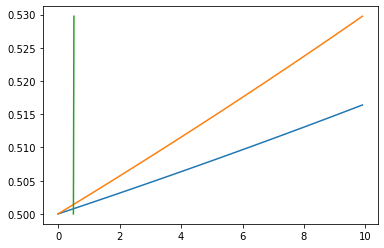

In [ ]:
simulate(recon_manuale,[0.5,0.5])

In [ ]:
simulate(recon_auto,[0.5,0.5])

ValueError: ignored

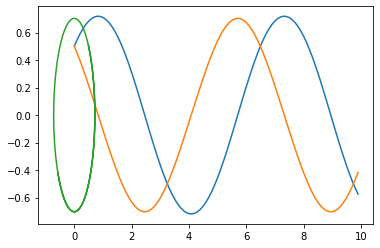

In [ ]:
simulate(pend,[0.5,0.5])

In [ ]:
simulate_torch(recon,[0.5,0.5])

In [ ]:
def simulate_torch(f,y0):
    ta = 0.
    tb = 10.
    dt = 0.1 
    t = torch.arange(ta, tb ,dt)
    
    #y0 = [ics[idx][0], ics[idx][1]]
    sol = odeint(f, y0,t)
    theta = sol[:,0]
    omega = sol[:,1]
    plt.plot(t,theta)

In [ ]:
simulate(pend,[0.5,0.5])

# plotting 

In [ ]:
x = X[:,:,0]
x.shape


In [ ]:
x = X[1][:,0]
y = X[2][:,1]
z = X[3][:,2]

In [ ]:
xdot = Xdot[1][:,0]
ydot = Xdot[2][:,1]
zdot = Xdot[3][:,2]

In [ ]:
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(x,y,z,linewidth=2)
ax1.view_init(azim=120)

In [ ]:
fig1 = plt.figure(figsize=(18,6))
ax1 = fig1.add_subplot(131)
ax1.plot(t,x)
ax1.plot(t,xdot,'r')

ax2 = fig1.add_subplot(132)
ax2.plot(t,y)
ax2.plot(t,ydot,'r')


ax3 = fig1.add_subplot(133)
ax3.plot(t,z)
ax3.plot(t,zdot,'r')
